In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()
# words[:8]

In [46]:
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [49]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print('\n',w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
            # print(''.join(itos[i] for i in context), '->', itos[ix], context)
    return torch.tensor(X), torch.tensor(Y)

X, Y = build_dataset(words)

In [133]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [134]:
print(Xtr.shape, Xtr)
print(Ytr.shape, Ytr)

torch.Size([182580, 3]) tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5,  2],
        ...,
        [25,  1, 14],
        [ 1, 14, 14],
        [14, 14,  9]])
torch.Size([182580]) tensor([ 5,  2, 18,  ..., 14,  9,  0])


In [176]:
# Initialize a random embedding table. After training our model, this will contain a vector for each character in our vocabulary.

# 27 characters, each has a 2D vector
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [177]:
sum(p.nelement() for p in parameters)

11897

In [178]:
for p in parameters:
    p.requires_grad = True

In [179]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs #Potential learning rates to try out. We will use these in the training loop below.

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [180]:
lri = [] # used learning rates
lossi = [] # loss values
stepi = [] # step values

In [192]:
for i in range(200000):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])    

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
        
print(loss.item())  
    

2.041290521621704


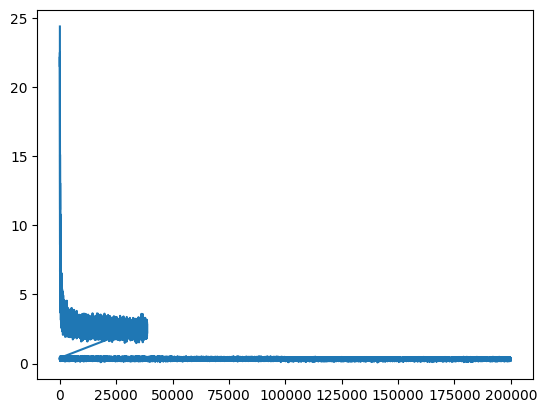

In [193]:
plt.plot(stepi, lossi)
# We'll find the Lr with lowest loss and use that to train a final model.

In [195]:
# Validation
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)    
loss.item()

2.150097370147705

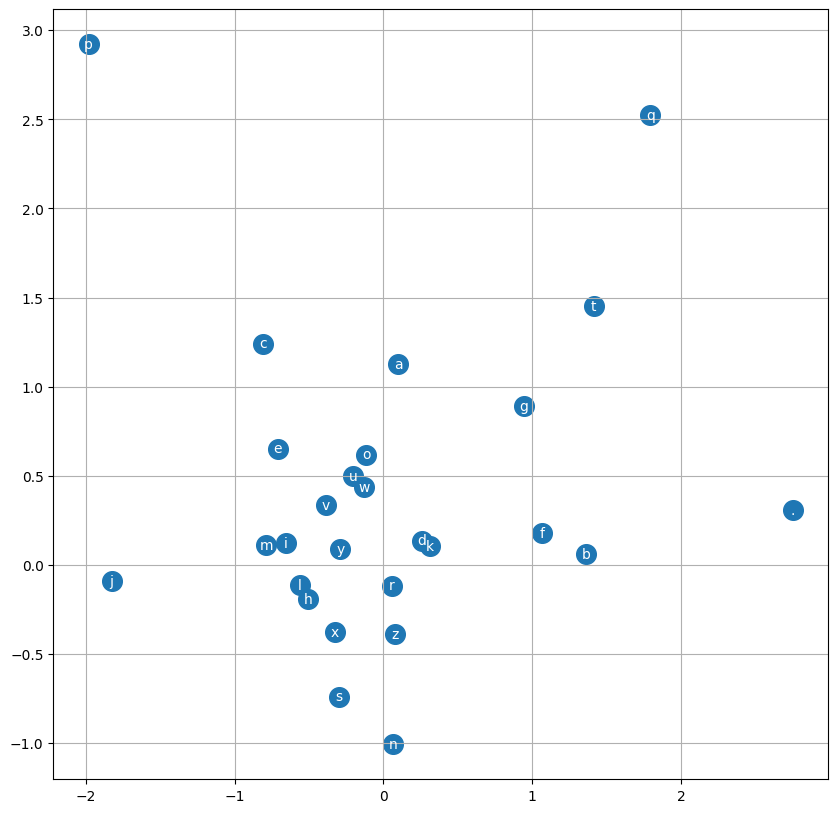

In [196]:
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')